<a href="https://colab.research.google.com/github/FridaVargas/Clasificacion-Multiclase-Celulas-Sanguineas/blob/main/ClasificacionMulticlaseCelulas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Clasificación automática de células sanguíneas a partir de imágenes:** comparación entre atributos GLCM y redes neuronales convolucionales
Frida Michelle Vargas Bautista



Introducción a la Ciencia de Datos en Escenarios Médicos-Biológicos

Semestre 2026-1

Profesores: David Alexis García Espinosa, Luis Eduardo Flores Luna y Derek Saúl Morán Pérez.


**_Información_:** Este trabajo tiene como objetivo explorar la clasificación multiclase de imágenes individuales de células sanguíneas periféricas, a través de dos enfoques: primero empleando la transformación a datos tabulares con la matriz de co-ocurrencia de niveles de gris (GLCM), calculando algunos de sus atributos para después hacer la clasificación con distintos algoritmos de clasificación de datos estructurados, entre ellos basados en ensables de árboles y máquinas de soporte vectorial. El segundo enfoque es construyendo una red neuronal con 3 capas de convoluciones y 3 profundas.


In [ ]:
####### Librerías iniciales #######

# Librerias empleadas para graficar
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# Librerias para manejar rutas de archivos, copiarlos y crearlos
from pathlib import Path
import shutil
import glob
import os

# Libreria para acceder a la API de kaggle y descargar el dataset
import kagglehub

# Librerias para analisis de imagenes y creacion de matriz GLCM
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray

# Librerias para analisis de datos y modelos de clasificacion
import random as rd
import tensorflow as tf
import pandas as pd
import numpy as np

## Información del _DataSet_ empleado

El _dataset_ empleado se encuentra disponible en _Kaggle_ y es posible visitarlo en este [link.](https://www.kaggle.com/datasets/unclesamulus/blood-cells-image-dataset/data?select=bloodcells_dataset)

Consta de un total de 17 092 imágenes de células sanguíneas individuales. Las imágenes fueron adquiridas mediante el analizador automatizado CellaVision DM96 en el Laboratorio Central del Hospital Clínic de Barcelona y se encuentran clasificadas por patólogos clínicos expertos.

 Las clases disponibles son: neutrófilos, eosinófilos, basófilos, linfocitos, monocitos, granulocitos inmaduros, eritroblastos y plaquetas.

### Descarga del _dataset_ desde _Kaggle_

In [ ]:
# Creo el directorio
os.makedirs('/kaggle/input/', exist_ok=True)

# Configuro la ruta de cache
os.environ['KAGGLEHUB_CACHE'] = '/content/kaggle/input/'

# Descargo el dataset
path = kagglehub.dataset_download("unclesamulus/blood-cells-image-dataset")

print("Ruta donde se descargo el dataset:", path)

Using Colab cache for faster access to the 'blood-cells-image-dataset' dataset.
Ruta donde se descargo el dataset: /kaggle/input/blood-cells-image-dataset


In [ ]:
# Creamos un diccionario donde sus elementos son los nombres de las carpetas y sus llaves asociadas son la abreviación de 2 letras para el nombre
# de cada archivo y el numero esta asociado a una imagen aleatoria del dataset
#Ejemplo: En la carpeta basophil se tienen imagenes que empiezan con BA, un elemento aleatorio de este folder es "BA_100102.jpg"
tipo_diccionario = {"basophil":["BA", 100102],
                    "eosinophil":["EO", 100213],
                    "erythroblast":["ERB", 101031],
                    "ig":["IG", 101958],
                    "lymphocyte":["LY", 100275],
                    "monocyte":["MO", 100695] ,
                    "neutrophil":["BNE", 100878],
                    "platelet":["PLATELET", 100161]}

Para mostrar el tipo de imágenes que contiene el _DataSet_ de imágenes sanguíneas se eligieron aleatorioamente un representante por cada clase, se muestran en la siguiente imagen junto con su tipo de célula:

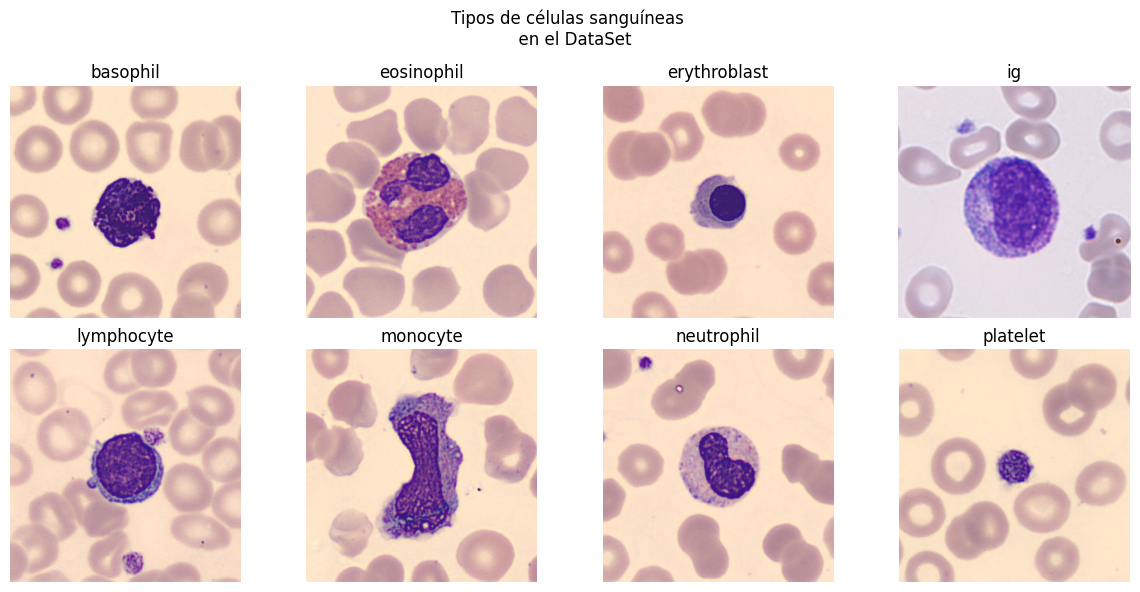

In [ ]:
figs, axes = plt.subplots(2,4, figsize=(12,6))
axes = axes.ravel()

for i, (tipo, descripcion) in enumerate(tipo_diccionario.items()):
  img = plt.imread(path+f"/bloodcells_dataset/{tipo}/{descripcion[0]}_{descripcion[1]}.jpg")
  axes[i].imshow(img)
  axes[i].set_title(tipo)
  axes[i].axis("off")

plt.suptitle("Tipos de células sanguíneas \n  en el DataSet")
plt.tight_layout()

## Enfoque de clasificación por atributos de matriz _GLCM_

En este _DataSet_ tenemos datos no estructurados pues están en formato de imágenes, por lo que no es viable emplear técnicas de clustering ni clasificación de manera directa, así como no se pueden sacar estadísticas tan cual de las imágenes que se tienen, entonces la pregunta es **_¿Existe una forma de convertir estos datos no estructurados a datos en forma tabular y obtener métricas de similitud o cercanía entre valores de los pixeles en cierta vecindad?_** De ser así, se puede explorar si existen rasgos característicos entre imágenes del mismo tipo celular, como contraste o texturas uniformes, y evaluar si estos pueden ser suficientes para diferenciar células sanguíneas.

Una propuesta, y la que se emplea en este trabajo, para convertir datos no estructurados a estructurados es la _Matriz de co-ocurrencia de niveles de gris, (GLCM)_ por sus siglas en inglés.
En este proceso, cada imagen se convierte a blanco y negro, por lo cual cada pixel tiene un valor de grís en cierta escala -dependiendo del programa, las usuales son valores entre 0 y 8 o 0 y 255-, después se compara el valor de cada pixel con el de algún otro (comunmente se compara con alguno de sus 8 vecinos directos) y se registra en una matriz con qué frecuencia un pixel salta de cierto valor a otro. Por ejemplo, si en la matriz la celda en la cordenada (234,200) tiene valor 5 significa que existen 5 parejas de pixeles de la imagen donde el pixel de referencia valía 234 y el valor del vecino es 200.

Lo que llega a verse obteniendo esta matriz es _qué tan frecuentemente_ un pixel de cierto valor puede tener un vecino con un valor muy diferente, o al revés, qué tan homogénea es la imagen al observar que no hay mucha variación en la intensidad de grises entre vecinos. En concreto, estos son algunos atributos que pueden estudiarse con la matriz GLCM aplicada a una imagen:
* **Contraste:** Mide la variación local en la imagen. Altos niveles de contraste indican mayor diferencias entre las intensidades de los pixeles en una vecindad.
* **Disimilaridad:** Promedia la diferencia de intensidades entre pixeles vecinos. Grandes valores indican mucha heterogeneidad en la textura.
* **Homogeneidad:** relaciona la distribución de elementos en la matriz con su diagonal, altos niveles de homogeneidad significan qur los elementos de la matriz están concentrados en su diagonal, lo que sugiere una textura más uniforme.
* **Energía**: Altos valores sugieren una textura más uniforme.
* **Correlación:** mide la dependencia lineal entre parejas de pixeles.



Creamos una función que por imagen, calcula la matriz GLCM y las 5 características mencionadas

In [ ]:
def caracteristicas_glcm(tipo, imagen):
  img_prueba = plt.imread(path+f"/bloodcells_dataset/{tipo}/{imagen}")
  # Convertimos la imagen a escala de grises usando skimage
  imagen_gris = (rgb2gray(np.array(img_prueba)) * 255).astype(np.uint8)
  # Calculamos la matriz GLCM con vecino derecho, se normaliza para que puedan ser comparables entre imagenes con diferente numero de pixeles, se usa la version simetrica para que sea mas robusta
  glcm= graycomatrix(imagen_gris, [1], [0], levels=256, normed=True, symmetric=True)
  # Calculamos energia, correlacion, homogeneidad, contraste y disimilaridad
  contraste = graycoprops(glcm, 'contrast')[0][0]
  correlacion = graycoprops(glcm, 'correlation')[0][0]
  homogeneidad = graycoprops(glcm, 'homogeneity')[0][0]
  disimilaridad = graycoprops(glcm, 'dissimilarity')[0][0]
  energia = graycoprops(glcm, 'energy')[0][0]
  return contraste, correlacion, homogeneidad, disimilaridad, energia




Probamos nuestra nueva función en una imagen y corrobar que funciona

In [ ]:
caracteristicas_glcm("monocyte", "MO_100695.jpg")

(np.float64(53.05284038153119),
 np.float64(0.9900894086254582),
 np.float64(0.5152711566607092),
 np.float64(3.251433044038767),
 np.float64(0.10715161027555137))

A continuación se eligen 200 elementos aleatorios por tipo de célula y se calcula su matriz GLCM, y se obtienen los 5 atributos anteriores, guardándolos en una tabla.


In [ ]:
#inicializamos listas
lista_tipo = []
lista_nombre = []
lista_contraste = []
lista_correlacion = []
lista_homogeneidad = []
lista_disimilaridad = []
lista_energia = []

# Recorremos el diccionario
# Semilla aleatoria
rd.seed(1509)
for tipo in tipo_diccionario:
  # Le pido que guarde todos los archivos .jpg de esta ruta
  imagenes = list(Path(path+f"/bloodcells_dataset/{tipo}").glob("*.jpg"))
  # Revolvemos aleatoriamente el orden de estas imágenes
  rd.shuffle(imagenes)
  # Ahora solo nos quedamos con las 1000 primeras
  muestra = imagenes[:1000]
  # Guardamos los atributos de la matriz LGCM definidas por cada imagen en la muestra
  for imagen in muestra:
    #guardamos su tipo y nombre por si se necesitan despues
    lista_tipo.append(tipo)
    lista_nombre.append(imagen.name)
    #guardamos los atributos de la matriz GLCM
    contraste, correlacion, homogeneidad, disimilaridad, energia = caracteristicas_glcm(tipo, imagen.name)
    lista_contraste.append(contraste)
    lista_correlacion.append(correlacion)
    lista_homogeneidad.append(homogeneidad)
    lista_disimilaridad.append(disimilaridad)
    lista_energia.append(energia)



In [ ]:
# Creamos un dataframe con las listas que habiamos inicializado
tabla_muestra = pd.DataFrame({"tipo":lista_tipo, "nombre":lista_nombre, "contraste":lista_contraste, "correlacion":lista_correlacion, "homogeneidad":lista_homogeneidad, "disimilaridad":lista_disimilaridad, "energia":lista_energia})

In [ ]:
tabla_muestra.head()

,tipo,nombre,contraste,correlacion,homogeneidad,disimilaridad,energia
0,basophil,BA_41844.jpg,33.889216,0.992452,0.537921,2.579195,0.139466
1,basophil,BA_72104.jpg,60.295050,0.988046,0.501481,3.220271,0.099077
2,basophil,BA_588625.jpg,44.308824,0.989357,0.537238,2.713437,0.088048
3,basophil,BA_359743.jpg,31.302593,0.991689,0.535935,2.386672,0.118526
4,basophil,BA_497822.jpg,34.882157,0.992355,0.522962,2.606536,0.099899


Y maravillosamente, ya tenemos datos estructurados y los podemos analizar como ya sabemos, ¡increible!

### Análisis Exploratorio de Datos

In [ ]:
tabla_muestra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tipo           8000 non-null   object 
 1   nombre         8000 non-null   object 
 2   contraste      8000 non-null   float64
 3   correlacion    8000 non-null   float64
 4   homogeneidad   8000 non-null   float64
 5   disimilaridad  8000 non-null   float64
 6   energia        8000 non-null   float64
dtypes: float64(5), object(2)
memory usage: 437.6+ KB


Se ve bien inicialmente, no hay datos nulos y parece se exportaron bien los 200 muestras por cada una de las 8 clases de células sangíneas.

In [ ]:
tabla_muestra.describe()

,contraste,correlacion,homogeneidad,disimilaridad,energia
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,30.091149,0.992114,0.546520,2.413581,0.132227
std,13.677161,0.002045,0.055068,0.597370,0.038478
min,4.448499,0.975849,0.285618,0.715133,0.032875
25%,19.777752,0.990834,0.507915,1.967677,0.104858
50%,29.352352,0.992191,0.542590,2.409920,0.127519
75%,38.141547,0.993521,0.583275,2.827931,0.154656
max,117.911546,0.997450,0.792072,6.347729,0.337804


Aquí podemos pensar que se van a presentar algunos problemas, ya que el percentil 50 y 75 están muy cercanos, en los atributos de _correlación, homogeneidad, disimilaridad y energía._ Esto nos quiere decir que la mitad de los valores y 3 cuartos de ellos están por debajo de valores muy muy similares, por lo que podríamos pensar que hay muy poca variación entre los mismos atributos. Sin embargo, recordemos que aquí están agrupados los atributos de todas las clases entonces puede ser que diferencias significativas que haya entre diferentes clases se puedan opacar con información de otras células.

Veamos si hay diferencias identificables a la vista empleando _boxplots_

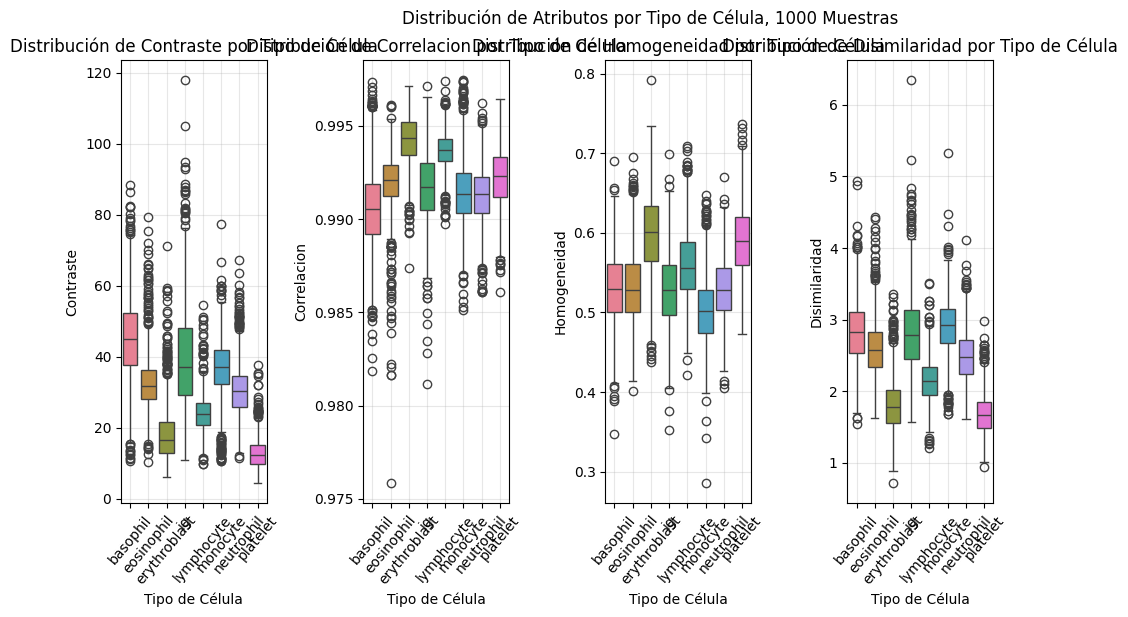

In [ ]:
atributos = ["contraste", "correlacion", "homogeneidad", "disimilaridad", "energia"]
figs, axes = plt.subplots(1, 5, figsize=(18, 6))
axes = axes.ravel()

for i, atributo in enumerate(atributos):
    sns.boxplot(data=tabla_muestra, x='tipo', y=atributo,
                ax=axes[i], hue='tipo', palette='husl', legend=False)

    axes[i].set_title(f"Distribución de {atributo.capitalize()} por Tipo de Célula")
    axes[i].set_xlabel('Tipo de Célula')
    axes[i].set_ylabel(atributo.capitalize())
    axes[i].grid(True, alpha=0.3)
    axes[i].tick_params(axis='x', rotation=50)

axes[-1].set_visible(False)

plt.tight_layout()
plt.suptitle("Distribución de Atributos por Tipo de Célula, 1000 Muestras", y=1.02)
plt.show()

Observamos algo muy problemático: hay demasiados _outliers_. Primero se probó usar 200 muestras pero pensando en que se puedan suavizar las distribuciones, se aumento el tamaño de la muestra a 1000, sin embargo, esto sólo acrecentó el nivel y número de valores atípicos.

La presencia de datos atípicos y que los brazos de las cajas abarquen rangos muy parecidos en cada atributo van a hacer mucho más compleja la labor de clasificación, por ende, quizás se deba optar por un enfoque de _aprendizaje profundo_ pero no saltemos a conclusiones sin antes haber agotado otros recursos.

## PCA  para _clustering_ de tipos celulares

Como un primer acercamiento, vamos a considerar la opción de usar PCA. Si los 2 o tres primeros componentes principales logran capturar al menos el 80% de variabilidad de los datos entonces podemos graficar cada punto - por cada imagen -  y primero ver si hay mucha dispersión o se agrupan por clústers bien diferenciados, de ser así buscamos los centroides con el algoritmo de _k-means_.

El objetivo de este trabajo no es hacer la implementación de estas herramientas desde cero entonces usaremos las ya definidas en otras paqueterías.

Procedemos con hacer una estandarización de datos en la tabla de muestras, este paso es vital para evitar que los componentes principales se sesgen ante magnitudes muy muy grandes.

Usualmente se hace una estandarización por columna, restando la media y dividiendo entre su desviación estándar, sin embargo, como hay muchos outliers y no queremos que los componentes principales se desvíen por ellos entonces restamos la mediana y dvidimos entre el rango intercuartil, esta acción está implementada en _RobustScaler_


In [ ]:
# Usamos solo el dataset con valores numericos
tabla_muestra_numerica = tabla_muestra.drop(columns=["tipo", "nombre"])
#Luego a este le aplicamos RobustScaler de sklearn
from sklearn.preprocessing import RobustScaler
tabla_muestra_robust = RobustScaler().fit_transform(tabla_muestra_numerica)

Después ya calculamos los componentes principales


In [ ]:
# importamos PCA de sklearn
from sklearn.decomposition import PCA
# Lo aplicamos a la tabla ya preprocesada
pca = PCA()
muestras_PCA = pca.fit(tabla_muestra_robust)


Veamos cuánta variabilidad capturan estos componentes

In [ ]:
# Revisamos la variabilidad que captura cada componente principal
np.cumsum(pca.explained_variance_ratio_)


array([0.69097218, 0.90426458, 0.9740156 , 0.99788053, 1.        ])

Nos dice que entre los dos primeros componentes principales se logra capturar el 90% de variabilidad del modelo, entonces podemos transformar el espacio a sólo dos componentes en lugar de usar 5 (una dimensión por atributo).

Con esto transformamos el espacio original a uno de sólo dos dimensiones y podemos graficar los puntos.

In [ ]:
# Primero usamos 2 componentes principales
pca2 = PCA(n_components=2)
muestras_PCA2 = pca2.fit_transform(tabla_muestra_robust)

In [ ]:
# Creamos un data frame donde tengamos las nuevas coordenadas y ademas le pasemos el tipo celular
tabla_muestra_PCA2 = pd.DataFrame(muestras_PCA2, columns=["PC1", "PC2"])
tabla_muestra_PCA2["tipo"] = tabla_muestra["tipo"]

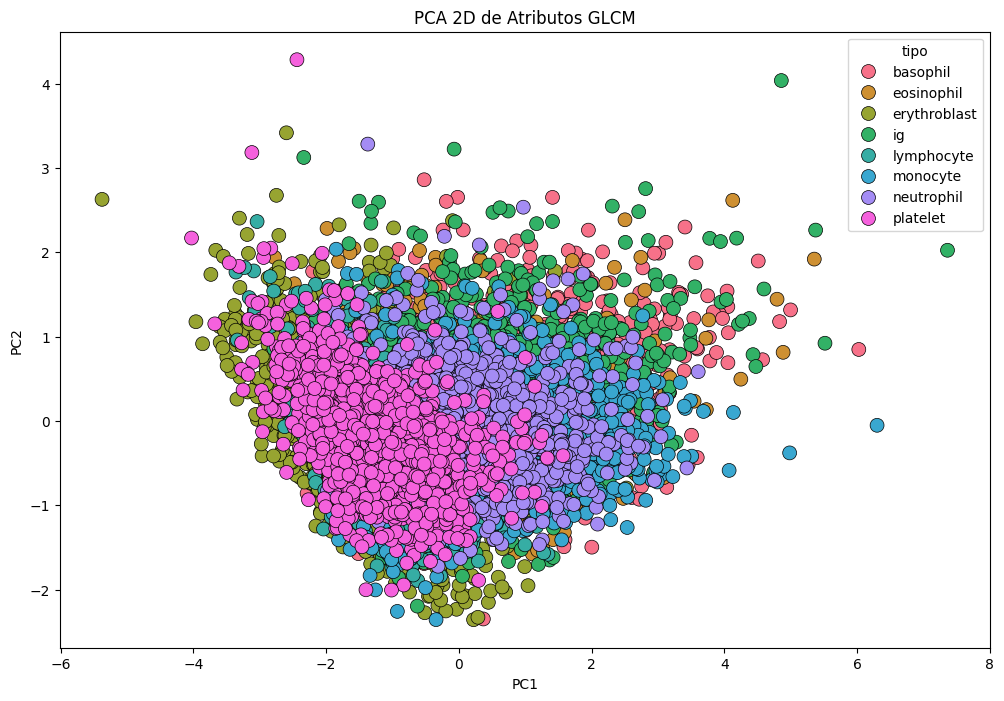

In [ ]:
# Procedemos a graficar
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=tabla_muestra_PCA2,
    x='PC1',
    y='PC2',
    hue='tipo',
    palette='husl',
    s=100,
    edgecolor='black',
    linewidth=0.5)
plt.title('PCA 2D de Atributos GLCM')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [ ]:
pca3 = PCA(n_components=3)
muestras_PCA3 = pca3.fit_transform(tabla_muestra_robust)

In [ ]:
# Creamos un data frame donde tengamos las nuevas coordenadas y ademas le pasemos el tipo celular
tabla_muestra_PCA3 = pd.DataFrame(muestras_PCA3, columns=["PC1", "PC2", "PC3"])
tabla_muestra_PCA3["tipo"] = tabla_muestra["tipo"]

In [ ]:
# Ahora graficamos con seaborns el PCA de tres dimensiones
import plotly.express as px

fig = px.scatter_3d(
    tabla_muestra_PCA3,
    x='PC1',
    y='PC2',
    z='PC3',
    color='tipo',
    color_discrete_sequence=px.colors.qualitative.Set2,
    opacity=1,
    height=600,
    title='PCA 3D de Atributos GLCM')

fig.update_traces(
    marker=dict(
        size=8,
        line=dict(width=0.5, color='black')))

fig.update_layout(
    showlegend=True,
    legend=dict(title='Tipo'))

fig.show()

Podemos observar que, desafortunadamente no se crean _clústers_ bien definidos que separen los diferentes tipos celulares sangíneas, en este nuevo espacio dado por los componentes principales. Sin embargo, antes de seguir con otros modelos de clasificación, me gustaría mencionar que no hay que descartar completamente este trabajo porque si bien, no se diferencian entre los 8 tipos iniciales, puede dar buenos resultados en diferenciar subconjuntos más pequeños de estas diferentes células sanguíneas.
Exploremos un poco al respecto basándonos en la gráfica inicial donde se ve que se agrupan bien las plaquetas

In [ ]:
# Seleccionamos plaquetas y otro tipo celular, por ejemplo los basophilos
subconjunto_1 = tabla_muestra_PCA3[(tabla_muestra_PCA3["tipo"] == "basophil") | (tabla_muestra_PCA3["tipo"] == "platelet")]
fig2 = px.scatter_3d(
    subconjunto_1,
    x='PC1',
    y='PC2',
    z='PC3',
    color='tipo',
    color_discrete_sequence=px.colors.qualitative.Set2,
    opacity=1,
    height=600,
    title='PCA 3D de Atributos GLCM')

fig2.update_traces(
    marker=dict(
        size=8,
        line=dict(width=0.5, color='black')))

fig2.update_layout(
    showlegend=True,
    legend=dict(title='Tipo'))

fig2.show()

Se observa que sí hay dos clústers bien diferenciados entre las imágenes de los basófilos y las plaquetas, entonces con una implementación  de _K-means_ o una _Support Vector Machine_, se puede resolver la clasificación entre una plaqueta y un basófilo.

Aún más, veamos qué resulta de la clasificación entre plaquetas y otros tipos celulares en general:

In [ ]:
#hacemos una copia de las muestras con coordenadas en componentes principales
subconjunto_2 = tabla_muestra_PCA3.copy()
# Cambiamos la etiqueta de los que no son plaqueta por otro
subconjunto_2.loc[subconjunto_2["tipo"] != "platelet", "tipo"] = "other"
#Veamos si lo hicimos bien al ver unique en la columna tipo
subconjunto_2["tipo"].unique()

array(['other', 'platelet'], dtype=object)

In [ ]:
# Procedemos a graficar:
fig3 = px.scatter_3d(
    subconjunto_2,
    x='PC1',
    y='PC2',
    z='PC3',
    color='tipo',
    color_discrete_sequence=px.colors.qualitative.Pastel,
    opacity=1,
    height=600,
    title='PCA 3D de Atributos GLCM')

fig3.update_traces(
    marker=dict(
        size=8,
        line=dict(width=0.5, color='black')))

fig3.update_layout(
    showlegend=True,
    legend=dict(title='Tipo'))

fig3.show()

Se observa que aunque no hay tanta separación como antes, sí hay una diferencia visual entre cómo se agrupan los atributos de la matriz LGCM de las imágenes de plaquetas y otros tipos celulares sanguíneos.

Podemos averiguar qué tan bien se separan estas dos clases empleando una _Support Vector Machine (SVM)_ que se encargará de encontrar un plano o hiperplano que separe a los elementos de las dos clases, lo logra al maximizar la distancia entre los puntos frontera entre ambas clases.

In [ ]:
# De sklearn importamos la SVM
from sklearn.svm import SVC
# importamos de plotly un go para el plano
import plotly.graph_objects as go

# Las coordenadas son los componentes principales
X = subconjunto_2.drop(columns=["tipo"])
# La variable objetivo es el tipo (plaqueta u otro)
Y = subconjunto_2["tipo"]

# Despues entrenamos a la SVM
svm = SVC(kernel='linear')
svm.fit(X, Y)

# Obtenemos los coeficientes y el termino independiente del plano
A, B, C = svm.coef_[0]
D = svm.intercept_[0]

# Creamos una malla para el plano
x_min, x_max = subconjunto_2['PC1'].min() - 1, subconjunto_2['PC1'].max() + 1
y_min, y_max = subconjunto_2['PC2'].min() - 1, subconjunto_2['PC2'].max() + 1

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 20),
                      np.linspace(y_min, y_max, 20))
# La ecuacion del plano es Ax + By + Cz + D = 0
# Para graficarlo necesitamos los valores de z entonces despejamos
zz = (-A * xx - B * yy - D) / C

#Le añadimos el hiperplano a la figura 3
fig3.add_trace(go.Surface(
    x=xx,
    y=yy,
    z=zz,
    opacity=0.6,
    colorscale="tealgrn",
    name="Plano SVM"))
# Graficamos
fig3.update_traces(showscale=False, selector=dict(type="surface"))
fig3.show()

Se ve bastante bien este resultado, incluso nos invita a probar el _truco de la dimensión_ donde al incrementar el número de dimensiones se pueden obtener resultados mucho mejores.

Por lo que, aunque no se obtuvieron los mejores resultados al clasificar entre 8 tipos diferentes, no vale la pena descartar por completo su uso para diferenciar entre plaquetas y otros tipos celulares que tengamos, sino que abre otras puertas, por ejemplo, al recibir un _dataset_ de células sanguíneas, el primer paso podría ser encontrar las que se pueden identificar como plaquetas y después emplear otros métodos más sofisticados para la clasificación del resto de imágenes en 7 categorías, lo cual podría ayudar a reducir el ruido y hacer que los algoritmos de clasificación se concentren en rasgos más finos que pueden diferenciar las demás células.

Este camino queda como una buena extensión para futuros trabajos, en esta ocasión nos concentraremos en implementaciones donde los algoritmos clasifiquen en 8 categorías directamente.

### Uso de modelos de clasificación sobre datos estructurados

El objetivo de esta sección será usar diferentes algoritmos de clasificación sobre los datos en coordenadas de componentes principales, ya estandarizados con _z-score_, y comparar su desempeño.
Los algoritmos que se usarán son los siguientes:
* _Random Forest_
* _Decision Tree_
* _Regresión Logística_
* _Gradient Boosting_
* _XGBoost_

Dado que el interés no es implementarlos, sólo ponerlos a prueba, se usarán los disponibles en librerías abiertas de _python_.

In [ ]:
# Importamos los modelos desde sus respectivas librerías
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

A nuestro _dataset_ lo dividimos en las secciones de _entrenaiento_ y _prueba_, primero usamos los datos sólo con el tratamiento del _z-score_

In [ ]:
# hacemos el tabla muestra robust un dataframe
tabla_muestra_robust = pd.DataFrame(tabla_muestra_robust, columns=tabla_muestra_numerica.columns)
tabla_muestra_robust["tipo"] = tabla_muestra["tipo"]

In [ ]:
from sklearn.preprocessing import LabelEncoder
# Vamos a codificar las clases en numeros del 0 al 7
le = LabelEncoder()
tabla_muestra_robust["tipo_cod"] = le.fit_transform(tabla_muestra_robust["tipo"])

In [ ]:
from sklearn.model_selection import train_test_split
# Dividimos el dataset en train y test
X_train1, X_test1, y_train1, y_test1 = train_test_split(tabla_muestra_robust.drop(columns=["tipo", "tipo_cod"]),
    tabla_muestra_robust["tipo_cod"], test_size=0.2)

In [ ]:
# Hacemos un diccionario con los modelos y algunos parametros
modelos = {'Random Forest': RandomForestClassifier(n_estimators=100, random_state=1509),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=1509),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=1509, eval_metric='mlogloss'),
    'SVM Poly': SVC(kernel='poly', random_state=1509),
    'SVM Linear': SVC(kernel='linear', random_state=1509),
    'SVM RBF': SVC(kernel='rbf', random_state=1509),
    'Logistic Regression': LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=1509)}

# Hacemos una lista con todas las metricas que queramos
metricas = ['accuracy', 'f1_micro', 'f1_macro', 'balanced_accuracy', 'precision_macro', 'recall_macro', "jaccard_macro"]



In [ ]:
# Creamos una lista para cada metrica
accuracy = []
f1_micro = []
f1_macro = []
balanced_accuracy = []
precision_macro = []
recall_macro = []
jaccard_macro = []
#una para el modelo
modelo_lista = []
# Vamos a descagar crossValidation
from sklearn.model_selection import cross_validate
# Para cada modelo se hace cross validation con 5 conjuntos y y se calculan todas las metricas necesarias
for nombre, modelo in modelos.items():
  resultados1 = cross_validate(modelo, X_train1, y_train1, cv=5, scoring=metricas)
  accuracy.append(resultados1["test_accuracy"].mean())
  f1_micro.append(resultados1["test_f1_micro"].mean())
  f1_macro.append(resultados1["test_f1_macro"].mean())
  balanced_accuracy.append(resultados1["test_balanced_accuracy"].mean())
  precision_macro.append(resultados1["test_precision_macro"].mean())
  recall_macro.append(resultados1["test_recall_macro"].mean())
  jaccard_macro.append(resultados1["test_jaccard_macro"].mean())
  modelo_lista.append(nombre)

# Lo hacemos a un dataframe
resultados_cv = pd.DataFrame({"modelo":modelo_lista, "accuracy":accuracy, "f1_micro":f1_micro, "f1_macro":f1_macro, "balanced_accuracy":balanced_accuracy,
                              "precision_macro":precision_macro, "recall_macro":recall_macro, "jaccard_macro":jaccard_macro})

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will 

In [ ]:
resultados_cv.sort_values(by="f1_macro", ascending=False)

,modelo,accuracy,f1_micro,f1_macro,balanced_accuracy,precision_macro,recall_macro,jaccard_macro
5,SVM RBF,0.611563,0.611563,0.605534,0.610815,0.612981,0.610815,0.461239
4,SVM Linear,0.600937,0.600937,0.594546,0.600205,0.598297,0.600205,0.452935
1,Gradient Boosting,0.593437,0.593437,0.589327,0.592759,0.592529,0.592759,0.444819
0,Random Forest,0.591406,0.591406,0.586692,0.590742,0.586545,0.590742,0.442768
2,XGBoost,0.587344,0.587344,0.584613,0.586705,0.585067,0.586705,0.441035
6,Logistic Regression,0.579375,0.579375,0.568663,0.578632,0.568317,0.578632,0.428185
3,SVM Poly,0.524844,0.524844,0.530623,0.524464,0.594005,0.524464,0.391304


Ahora veamos cómo les va a los datos con PCA de tres dimensiones

In [ ]:
tabla_muestra_PCA3["tipo_cod"] = le.fit_transform(tabla_muestra_PCA3["tipo"])
# Dividimos el dataset en train y test
X_train2, X_test2, y_train2, y_test2 = train_test_split(tabla_muestra_PCA3.drop(columns=["tipo", "tipo_cod"]),
    tabla_muestra_PCA3["tipo_cod"], test_size=0.2)

# Creamos una lista para cada metrica
accuracy2 = []
f1_micro2 = []
f1_macro2 = []
balanced_accuracy2 = []
precision_macro2 = []
recall_macro2 = []
jaccard_macro2 = []
#una para el modelo
modelo_lista2 = []
# Para cada modelo se hace cross validation con 5 conjuntos y y se calculan todas las metricas necesarias
for nombre, modelo in modelos.items():
  resultados2 = cross_validate(modelo, X_train2, y_train2, cv=5, scoring=metricas)
  accuracy2.append(resultados2["test_accuracy"].mean())
  f1_micro2.append(resultados2["test_f1_micro"].mean())
  f1_macro2.append(resultados2["test_f1_macro"].mean())
  balanced_accuracy2.append(resultados2["test_balanced_accuracy"].mean())
  precision_macro2.append(resultados2["test_precision_macro"].mean())
  recall_macro2.append(resultados2["test_recall_macro"].mean())
  jaccard_macro2.append(resultados2["test_jaccard_macro"].mean())
  modelo_lista2.append(nombre)

# Lo hacemos a un dataframe
resultados_cv2 = pd.DataFrame({"modelo":modelo_lista2, "accuracy":accuracy2, "f1_micro":f1_micro2, "f1_macro":f1_macro2, "balanced_accuracy":balanced_accuracy2,
                              "precision_macro":precision_macro2, "recall_macro":recall_macro2, "jaccard_macro":jaccard_macro2})

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will 

In [ ]:
resultados_cv2.sort_values(by="f1_macro", ascending=False)

,modelo,accuracy,f1_micro,f1_macro,balanced_accuracy,precision_macro,recall_macro,jaccard_macro
5,SVM RBF,0.504219,0.504219,0.498884,0.503992,0.509271,0.503992,0.354450
4,SVM Linear,0.497188,0.497188,0.490471,0.497388,0.495230,0.497388,0.347741
1,Gradient Boosting,0.493594,0.493594,0.490344,0.493630,0.494624,0.493630,0.344758
6,Logistic Regression,0.490312,0.490312,0.480854,0.490598,0.480571,0.490598,0.340762
0,Random Forest,0.470313,0.470313,0.468314,0.470453,0.468604,0.470453,0.326817
2,XGBoost,0.466250,0.466250,0.464721,0.466456,0.465552,0.466456,0.323697
3,SVM Poly,0.448750,0.448750,0.448398,0.448184,0.512762,0.448184,0.313078


Se observa que en general, bajan los valores de las métricas.

### Matriz de Confusión del mejor modelo

A cotinuación vamos a calcular la matriz de confusión del mejor modelo obtenido (SVM con kernel RBF) y la graficamos.

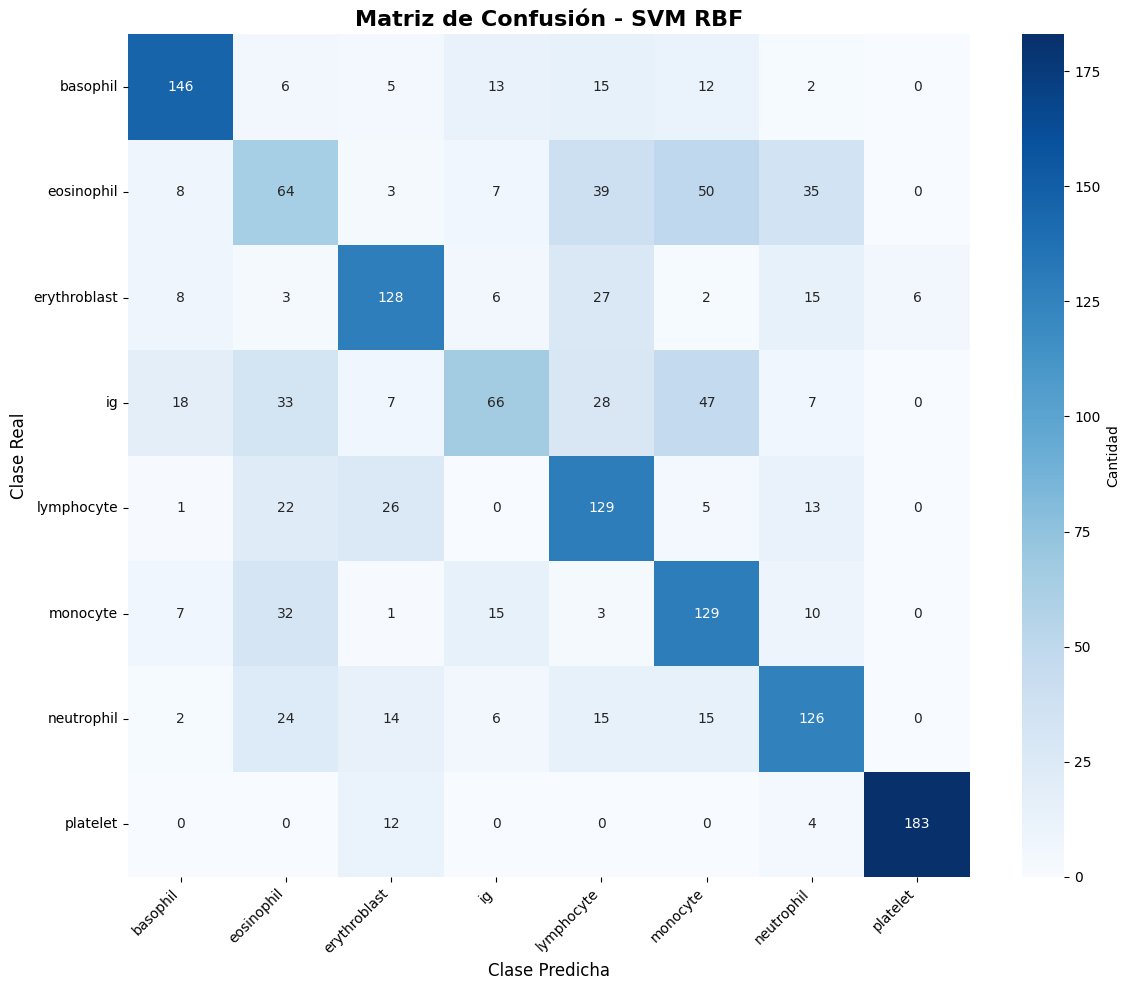

In [ ]:
from sklearn.metrics import confusion_matrix

# Volvemos a entrenar el modelo que mejor desemeño tuvo
mejor_modelo = SVC(kernel='rbf', random_state=1509)
mejor_modelo.fit(X_train1, y_train1)

# predecimos en los datos de prueba
y_pred = mejor_modelo.predict(X_test1)

#   Creamos la matriz de confusión
cm = confusion_matrix(y_test1, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            cbar_kws={'label': 'Cantidad'})
plt.title('Matriz de Confusión - SVM RBF', fontsize=16, fontweight='bold')
plt.ylabel('Clase Real', fontsize=12)
plt.xlabel('Clase Predicha', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

El siguiente paso es entrenar una Red Neuronal Convolucional y comparar su desempeño con los clasificadores de datos estructurados.

Para ello creamos las carpetas de prueba entrenamiento y clasificación que _keras_ necesita para trabajar más facilmente.

In [ ]:
# Las clases en las que dividiremos los datos de cada tipo celular
clases = np.array(["entrenamiento", "prueba", "validacion"])
# Se crean las carpetas en las rutas especificadas con esos nombres
for tipo in tipo_diccionario:
  for clase in clases:
    Path(f"/kaggle/wd/{clase}/{tipo}").mkdir(parents=True, exist_ok=True)
# Ahora especificamos las proporciones para cada fase
prop_entrenamiento = 0.7
prop_prueba = 0.15
prop_validacion = 0.15

In [ ]:
# Usamos las mismas imágenes para los datos no estructurados, guardados en la tabla muestra
tabla_muestra[["tipo", "nombre"]]
# Por cada tipo y nombre en tabla muestra los primeros 700 de cada tipo los ponemos en la carpeta de entrenamiento, las siguientes 150 en validación y las otras en prueba

,tipo,nombre
0,basophil,BA_41844.jpg
1,basophil,BA_72104.jpg
2,basophil,BA_588625.jpg
3,basophil,BA_359743.jpg
4,basophil,BA_497822.jpg
...,...,...
7995,platelet,PLATELET_919469.jpg
7996,platelet,PLATELET_370200.jpg
7997,platelet,PLATELET_93514.jpg
7998,platelet,PLATELET_631625.jpg


In [ ]:
for idx, row in tabla_muestra.iterrows():
    tipo = row['tipo']
    nombre = row['nombre']

    # Usar módulo para que se reinicie automáticamente cada 1000
    contador = idx % 1000

    # Determinar carpeta destino según el contador
    if contador < 700:
        carpeta_destino = 'entrenamiento'
    elif contador < 850:
        carpeta_destino = 'validacion'
    else:
        carpeta_destino = 'prueba'

    # Copiar imagen
    origen = f"{path}/bloodcells_dataset/{tipo}/{nombre}"
    destino = f"/kaggle/wd/{carpeta_destino}/{tipo}/{nombre}"
    shutil.copy(origen, destino)

In [ ]:
def reescalar_tamanio(imagen):
  # Pedimos el tamaño (numero de pixeles horizontales y verticales) de la imagen
  dimensiones = tf.shape(imagen)
  # Ahora obtenemos la altura y el ancho por separado y declaramos que sean numeros reales para admitan un cociente real en el futuro
  altura = tf.cast(dimensiones[0], tf.float32)
  ancho = tf.cast(dimensiones[1], tf.float32)
  # Ahora suponiendo que el ancho y el alto tienen diferente numero de pixeles, para calcular la escala nos quedamos con el min
  escala = tf.maximum(128/altura, 128/ancho)
  # Calculamos el tamaño del nuevo alto y ancho
  nuevo_alto = tf.cast(altura*escala, tf.int32)
  nuevo_ancho = tf.cast(ancho*escala, tf.int32)
  #Hacemos el resize de la imagen con las medidas de alto y ancho
  imagen = tf.image.resize(imagen, [nuevo_alto, nuevo_ancho])
  # Y ya para que queden cuadradas hacemos crop
  imagen = tf.image.resize_with_crop_or_pad(imagen, 128, 128)
  return imagen

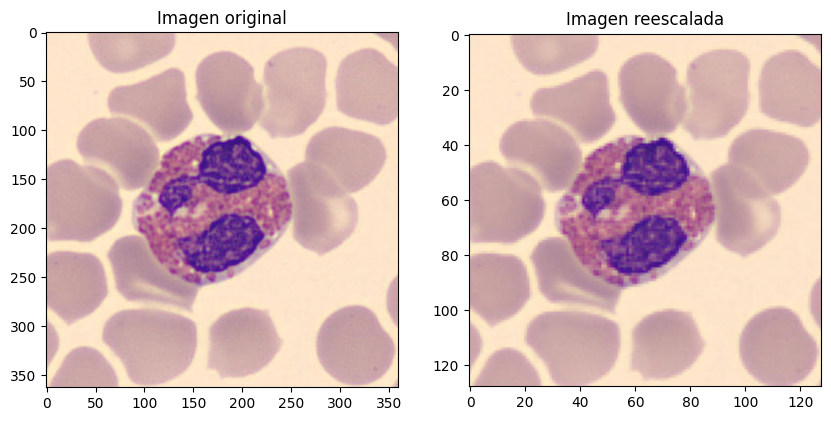

In [ ]:
img_prueba = plt.imread(path+"/bloodcells_dataset/eosinophil/EO_100213.jpg")
img_reescalada = reescalar_tamanio(img_prueba)

#comparamos las dos imagenes
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img_prueba)
axes[0].set_title("Imagen original")
axes[1].imshow(img_reescalada.numpy().astype(np.uint8))
axes[1].set_title("Imagen reescalada")
plt.show()

In [ ]:
def reescalar_intensidad(imagen):
  imagen = tf.cast(imagen, tf.float32)/255.0
  return imagen

In [ ]:
def estandarizar(imagen):
  imagen1 = reescalar_intensidad(imagen)
  imagen2 = reescalar_tamanio(imagen1)
  return imagen2

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
preparacion_validacion = ImageDataGenerator(preprocessing_function=estandarizar)
preparacion_prueba = ImageDataGenerator(preprocessing_function=estandarizar)
# Ahora para los datos de entrenamiento vamos a agregarle la estandarizacion de intensidad y tamaño pero tambien
# hacemos data augmentation con transformaciones que no afectan la morfologia de la celula
preparacion_entrenamiento = ImageDataGenerator( preprocessing_function=estandarizar,
                                                horizontal_flip=True,
                                                vertical_flip=True)

In [ ]:
generar_entrenamiento = preparacion_entrenamiento.flow_from_directory("/kaggle/wd/entrenamiento",
                                              batch_size=32,
                                              class_mode="categorical",
                                              target_size=(128,128))
generar_validacion = preparacion_validacion.flow_from_directory("/kaggle/wd/validacion",
                                              batch_size=32,
                                              class_mode="categorical",
                                              target_size=(128,128))
generar_prueba = preparacion_prueba.flow_from_directory("/kaggle/wd/prueba",
                                              batch_size=32,
                                              class_mode="categorical",
                                              target_size=(128,128),
                                              shuffle = False)

Found 5600 images belonging to 8 classes.
Found 1200 images belonging to 8 classes.
Found 1200 images belonging to 8 classes.


Procedemos a descargar las herramientas para la red neuronal en keras

In [ ]:
from tensorflow.keras.models import Sequential # El modelo será construido de tipo secuencial
from tensorflow.keras.optimizers import Adam # El tipo de optmizador sera Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

In [ ]:
# Declaramos al modelo secuancial
modelo = Sequential()

# Bloque 1: 32 filtros
# Agregamos una capa convolucional de 32 filtros que recibe imágenes con valores en los tres canales RGB y son de tamanio 128x128, la activacion es relu
modelo.add(Conv2D(32, (3, 3), activation='relu', padding='same',
                  input_shape=(128, 128, 3)))
# Que normalice los batches para una prpagacion de informacion mas estable
modelo.add(BatchNormalization())
# Para reducir operaciones hacemos un pooling, en particular en cuadrados de dos por dos pixeles vamos a conservar el valor maximo
modelo.add(MaxPooling2D(pool_size=(2, 2)))
modelo.add(Dropout(0.25))

# Bloque 2: 64 filtros
modelo.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
modelo.add(BatchNormalization())
modelo.add(MaxPooling2D(pool_size=(2, 2)))
modelo.add(Dropout(0.25))

# Bloque 3: 128 filtros
modelo.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
modelo.add(BatchNormalization())
modelo.add(MaxPooling2D(pool_size=(2, 2)))
modelo.add(Dropout(0.25))

# Capas densas
modelo.add(Flatten())
modelo.add(Dense(64, activation='relu'))
modelo.add(BatchNormalization())
modelo.add(Dropout(0.5))

modelo.add(Dense(128, activation='relu'))
modelo.add(BatchNormalization())
modelo.add(Dropout(0.5))

# Capa de salida
# Con softmax para que asigne probabilidades a las 8 clases, que son los ultimos 8 nodos finales
modelo.add(Dense(8, activation='softmax'))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [ ]:
# Compilamos el modelo: aquí se define cómo va a aprender
modelo.compile(
    ## Optimizador Adam: ajusta los pesos usando gradiente, lr controla el tamanio del paso
    optimizer=Adam(learning_rate=0.001),
    # Funcion de perdida para clasificacion multiclase con etiquetas one-hot
    loss='categorical_crossentropy',
    # # Metrica para monitorear durante entrenamiento: porcentaje de aciertos
    metrics=['accuracy'])


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping # Son callbacks que guardan informacion de como lo esta haciendo el modelo
# Y nos serviran para cuando un modelo se este sobreajustando (mejora en entrenamiento empeora en validacion) se detenga y guarde los ultimos pesos de la mejor configuracion previa

# Guarda solo el mejor modelo
checkpoint = ModelCheckpoint(
    filepath='/kaggle/wd/mejor_modelo.keras',  # en donde se guarda el mejor
    monitor='val_accuracy',           # métrica a monitorear, accuracy en validacion
    save_best_only=True,              # solo guarda si mejora
    mode='max',                       # 'max' para accuracy
    verbose=1 )                      # imprime informacion

# Detiene el entrenamiento si no mejora
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=2,                       # espera 2 epochs sin mejora
    restore_best_weights=True,        # restaura los mejores pesos al final
    verbose=1)                        # imprime informacion

# Entrenar con los callbacks para que se detenga llegado el momento
historia = modelo.fit(
    generar_entrenamiento,
    epochs=50,                        # Ponemos un maximo de epocas de 50 pero puede que se detenga antes si el monitor empieza a empeorar
    validation_data=generar_validacion,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8605 - loss: 0.4219
Epoch 1: val_accuracy improved from -inf to 0.36667, saving model to /kaggle/wd/mejor_modelo.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 377s 2s/step - accuracy: 0.8605 - loss: 0.4218 - val_accuracy: 0.3667 - val_loss: 33.1941
Epoch 2/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8861 - loss: 0.3402
Epoch 2: val_accuracy improved from 0.36667 to 0.78667, saving model to /kaggle/wd/mejor_modelo.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 372s 2s/step - accuracy: 0.8861 - loss: 0.3403 - val_accuracy: 0.7867 - val_loss: 2.2144
Epoch 3/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8952 - loss: 0.3248
Epoch 3: val_accuracy did not improve from 0.78667
175/175 ━━━━━━━━━━━━━━━━━━━━ 364s 2s/step - accuracy: 0.8952 - loss: 0.3248 - val_accuracy: 0.7075 - val_loss: 11.3604
Epoch 4/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9055 - loss: 0.2723
Epoch 4: val_accuracy did not improve from 0.78667
1

Se observa que se detuvo en la segunda época, donde el _accuracy_ en la validación alcanzó su máximo que fue 79%. Procedemos a probar en los datos de prueba.

In [ ]:
modelo.evaluate(generar_prueba)

38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 513ms/step - accuracy: 0.7024 - loss: 2.4451


[2.1271822452545166, 0.7816666960716248]

El _accuracy_ fue ligeramente menor pero esperable pues son imagenes que nunca antes habá visto pero en general también es bastante aceptable.

Se realiza una prueba de predicción al seleccionar una imagen aleatoria de la clase _ig_ y que la red intente predecir a qué clase pertenece.

In [ ]:
img_test = plt.imread(path+"/bloodcells_dataset/ig/IG_101958.jpg")
img_test = estandarizar(img_test)
img_t = np.expand_dims(img_test, axis=0) # Hacemos el tratamiento de la foto para que pueda introducirse a la red neuronal

In [ ]:
modelo.predict(img_t) # Le decimos que prediga, y en el index donde se concentre la mayor probabilidad devuelva la clase que esta en ese index en el listado de tipos celulaes originales
class_names = list(generar_entrenamiento.class_indices.keys())
idx = np.argmax(modelo.predict(img_t))
class_names[idx]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


'platelet'

Se observa se equivocó jajaj, pero veamos cómo lo hace por cada clase al calcular su matriz de confusión y su f1-macro para comparar con el mejor modelo, SVM.

38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 555ms/step


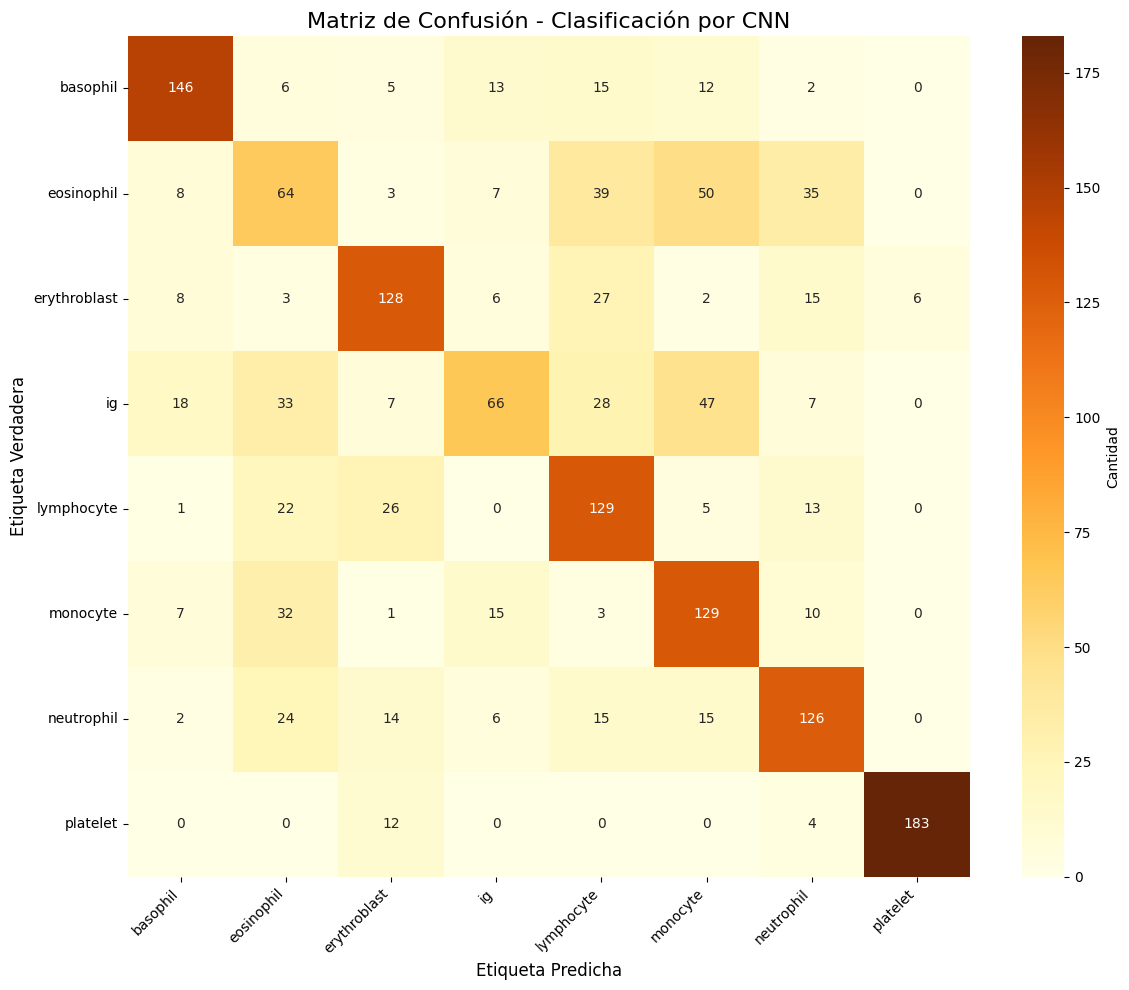

In [ ]:

# Reiniciamos el generador para asegurar que empiece desde el inicio
generar_prueba.reset()

# Obtenemos las predicciones del modelo sobre el conjunto de prueba
predicciones = modelo.predict(generar_prueba, steps=len(generar_prueba))

# Ahora seleccionamos los index que tuvieron las probas mas grandes por imagen
y_pred2 = np.argmax(predicciones, axis=1)

# Aqi guardamos los labels verdaderos
y_true2 = generar_prueba.classes

# Visualizamos la matriz de confusion
nombres_clases = list(generar_prueba.class_indices.keys())
cm2 = confusion_matrix(y_true2, y_pred2)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap="YlOrBr",
            xticklabels=nombres_clases,
            yticklabels=nombres_clases,
            cbar_kws={'label': 'Cantidad'})
plt.title('Matriz de Confusión - Clasificación por CNN', fontsize=16)
plt.ylabel('Etiqueta Verdadera', fontsize=12)
plt.xlabel('Etiqueta Predicha', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



In [ ]:
# Calculamos el f1 score para comparar con los otros modelos
from sklearn.metrics import f1_score
f1_score(y_true2, y_pred2, average='macro')

0.7708498570158373